In [201]:
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [202]:
TRAIN_PATH = 'dataset/train.csv'
TEST_PATH = 'dataset/test.csv'

In [203]:
df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [204]:
def modify_df(df):
    df['Id'] = df['PassengerId'].apply(lambda x : x[5:])
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notna(x) else x)
    df['Num'] = df['Cabin'].apply(lambda x: x.split('/')[1] if pd.notna(x) else x)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if pd.notna(x) else x)
    return df

df = modify_df(df)
test_df = modify_df(test_df)

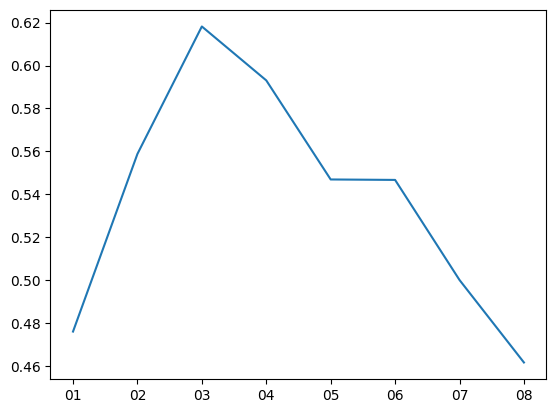

In [205]:
# percentage_missing_by = df.groupby('Age')['Transported'].sum() / df.groupby('Age')['Transported'].count()
# percentage_missing_by = df.groupby('VIP')['Transported'].sum() / df.groupby('VIP')['Transported'].count()
# percentage_missing_by = df.groupby('HomePlanet')['Transported'].sum() / df.groupby('HomePlanet')['Transported'].count()
percentage_missing_by = df.groupby('Id')['Transported'].sum() / df.groupby('Id')['Transported'].count()
plt.plot(percentage_missing_by)

In [206]:
y = df['Transported']
X = df.drop(columns=['PassengerId', 'Transported', 'Name', 'Destination', 'Cabin'], axis=1)
X_test = test_df.drop(columns=['PassengerId', 'Name', 'Destination', 'Cabin'], axis=1)

In [207]:
categories_col = [col for col in X.columns if df[col].dtype == object and col != 'PassengerId' and col != 'Num']
numeric_col = [col for col in X.columns if col not in categories_col or col == 'Num']

In [208]:
categories_col

['HomePlanet', 'CryoSleep', 'VIP', 'Id', 'Deck', 'Side']

In [209]:
numeric_col

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num']

In [210]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Id,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,01,F,1,S


In [211]:
X

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id,Deck,Num,Side
0,Europa,False,39.0,False,0.0,0.0,0.0,0.0,0.0,01,B,0,P
1,Earth,False,24.0,False,109.0,9.0,25.0,549.0,44.0,01,F,0,S
2,Europa,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,01,A,0,S
3,Europa,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,02,A,0,S
4,Earth,False,16.0,False,303.0,70.0,151.0,565.0,2.0,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,01,A,98,P
8689,Earth,True,18.0,False,0.0,0.0,0.0,0.0,0.0,01,G,1499,S
8690,Earth,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,01,G,1500,S
8691,Europa,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,01,E,608,S


In [212]:
numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())]
)
categories_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(sparse_output=True, handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transform, numeric_col),
    ('categories', categories_transform, categories_col)]
)
preprocessor.fit(X)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck', 'Num']),
                                ('categories',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['HomePlanet', 'CryoSleep', 'VIP', 'Id',
                                  'Deck', 'Side'])])

In [213]:
X = preprocessor.transform(X)
X_test = preprocessor.transform(X_test)

In [214]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [215]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
rf = RandomForestClassifier(random_state=42)

In [217]:
from sklearn.model_selection import cross_val_score, GridSearchCV
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f"CV mean score: {cv_scores.mean()}")

CV mean score: 0.7982460731630369


In [218]:
param_grid = {
    'n_estimators': [300],  # Số lượng cây quyết định
    'max_depth': [None, 5, 10, 15, 20],  # Độ sâu tối đa của cây
    'min_samples_split': [5],  # Số lượng mẫu tối thiểu để chia một nút
    'min_samples_leaf': [1, 2, 3, 4, 5],  # Số lượng mẫu tối thiểu tại một lá cây
    'bootstrap': [True, False]  # Phương pháp lấy mẫu cho việc xây dựng cây
}

# Tạo mô hình GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit mô hình Grid Search
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [224]:
predictions = best_rf.predict(X_val)
print(accuracy_score(y_val, predictions))

0.8021851638872916


In [225]:
best_rf

RandomForestClassifier(bootstrap=False, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [221]:
predictions_test = best_rf.predict(X_test)

In [222]:
 passenger_id = test_df['PassengerId'].tolist()
 transported = predictions_test
 
 submission = pd.DataFrame({
    "PassengerId": passenger_id,
    "Transported": label_encoder.inverse_transform(predictions_test)
 })

In [223]:
submission.to_csv('submission.csv', index=False)